In [19]:
import numpy
import pandas
import os
import tkinter as tk
import tkinter.filedialog as fd# Constants
import matplotlib.pyplot as plt

In [20]:
# Constants
rhoAl = 2.65 * 10 ** -8  #Ohm m 
ls = 20 * 10 ** -6 # Signal line length
lgr = 20 * 10 ** -6 # Ground line length
lp = 2.1 * 10 ** -6 # Short circuit length

tAl = 100 * 10 ** -9 # Thickness of the Al/Ti antennas (90nm Al/10 nm Ti)

ws = 810 * 10 ** -9 # Width of the signal line
wgr = 450 * 10 ** -9 # width of the ground line
wp = 2.1 * 10 ** -6 # width of the short circuit section

As = tAl * ws # Area of the signal line
Agr = tAl * wgr # Area of the ground line
Ap = tAl * wp # Area of the short circuit section

In [21]:
def Resistance(rho, A, l):
    return (rho * l)/A

def SheetResistance(rho, thickness, width):
    return rho / (thickness * width)

def TotalResistance(signal, ground, pad):
    return signal + (ground + pad)/2

In [22]:
def Y11(f, Ycss):
    return Ycss / 2 * 2*numpy.pi*f

def Zcharacteristic(f, Ycss, Rsignal, Rground):
    return numpy.sqrt(2 * Rsignal * Y11(f, Ycss) + Rground * Y11(f, Ycss)) / (2 * Y11(f, Ycss))

def ZL(s11, zc):
    return zc * (1+s11)/(1-s11)

def S11(zl, zc):
    return (zl-zc)/(zl+zc)

In [59]:
import scipy.interpolate

def InterpolateData(y, x, xnew):
    interpFunc = scipy.interpolate.interp1d(x, y, fill_value = "extrapolate")
    return interpFunc(xnew)

def InterpolateComplexSeries(series, x, xnew):
    real = series.to_numpy().real
    imag = series.to_numpy().imag
    
    newReal = InterpolateData(real, x, xnew)
    newImag = InterpolateData(imag, x, xnew)
    
    return pandas.Series(newReal+1j*newImag)
    

def InterpolateABCD(ABCDpandas, oldFreqs, newFreqs):
    output = ABCDpandas.apply(InterpolateComplexSeries, args=(oldFreqs, newFreqs))
    return output

In [60]:
from scipy.signal import savgol_filter

def SmoothDataFrame(dataFrame, window, polyOrder):
    output = dataFrame
    
    for col in output:
        real = numpy.real(output[col].to_numpy())
        imag = numpy.imag(output[col].to_numpy())
        
        real = savgol_filter(real, window, polyOrder)
        imag = savgol_filter(imag, window, polyOrder)
        output[col] = real + imag * 1j
    return output

# 1. Load in the Simulated data such that we can calculate the characteristic impedance and S11 of the antenna

In [96]:
root = tk.Tk()
file = fd.askopenfilename(parent=root, initialdir="H:\\My Documents\\Physics\\PhD Work\\Simulation Code\\Python Simulation Results", title="S11 of antenna")
root.withdraw()
file

'//uniwa.uwa.edu.au/userhome/students6/22159666/My Documents/Physics/PHD Formal/Publications/Spin-wave Papers/Data/1.SimulationForS11-NewCorrection/2022-05-15_distance_Antennas_-2.464e-06_600Oe_corrected_20220515_ref.csv'

In [97]:
p_S11ant = pandas.read_csv(file, header=0, delimiter=',')

print(p_S11ant)

     # Frequency   Real(S11)   Imag(S11)   Amp(S11)   Phase(S11)   Real(E0)  \
0   7.000000e+09   -0.602347    0.010094   0.602431     3.124837  -0.166796   
1   7.111111e+09   -0.602343    0.010255   0.602431     3.124568  -0.173130   
2   7.222222e+09   -0.602340    0.010417   0.602430     3.124300   1.697864   
3   7.333333e+09   -0.602339    0.010579   0.602432     3.124031  -0.230607   
4   7.444444e+09   -0.602335    0.010741   0.602431     3.123762  -0.237557   
..           ...         ...         ...        ...          ...        ...   
95  1.755556e+10   -0.601779    0.025589   0.602323     3.099097  -1.372857   
96  1.766667e+10   -0.601770    0.025753   0.602321     3.098823  -1.391635   
97  1.777778e+10   -0.601761    0.025918   0.602319     3.098549  -1.410570   
98  1.788889e+10   -0.601752    0.026082   0.602317     3.098276  -1.429664   
99  1.800000e+10   -0.601744    0.026247   0.602316     3.098002  -1.448918   

     Imag(E0)    Amp(E0)   Phase(E0)   Real(E1)  ..

# Let's calculate the characterisic impedance of the antenna
# Then calculate the corresponding S11 parameter for this characteristic impedance

In [98]:
import scipy.optimize

def Polynomial(x, a, b, c):
    return a*x**2 + b*x + c

def Exponent(x, a, b, c):
    return a * numpy.exp(-b*x) + c

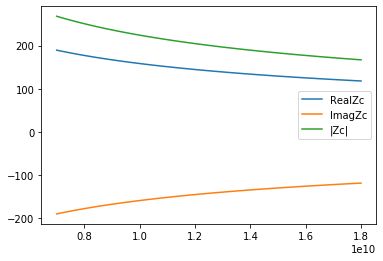

In [99]:
Ycss = 1.9680 * 10 ** -10 * 1j
SheetResistanceSignal = SheetResistance(rhoAl, tAl, ws)
SheetResistanceGround = SheetResistance(rhoAl, tAl, wgr)
frequencies = p_S11ant["# Frequency"].to_numpy()
#frequencies = numpy.linspace(1*10**9, 25*10**9, 1601)

zcharacteristic = Zcharacteristic(frequencies, Ycss, SheetResistanceSignal, SheetResistanceGround)

plt.plot(frequencies, zcharacteristic.real, label = "RealZc")
plt.plot(frequencies, zcharacteristic.imag, label = "ImagZc")
plt.plot(frequencies, numpy.absolute(zcharacteristic), label = "|Zc|")
plt.legend()
plt.show()

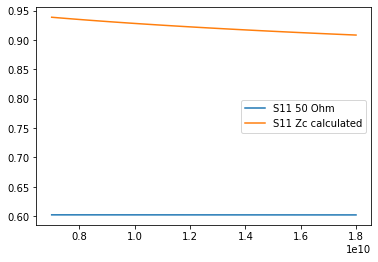

In [100]:
S11FiftyOhm = p_S11ant[" Real(S11)"] + 1j * p_S11ant[" Imag(S11)"]
Zload = ZL(S11FiftyOhm, 50)

S11Characteristic = S11(Zload, zcharacteristic)

plt.plot(frequencies, numpy.absolute(S11FiftyOhm), label="S11 50 Ohm")
plt.plot(frequencies, numpy.absolute(S11Characteristic), label = "S11 Zc calculated")
plt.legend()
plt.show()

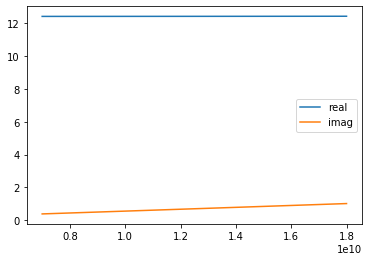

12.409853124352486


In [101]:
plt.plot(frequencies, Zload.to_numpy().real, label="real")
plt.plot(frequencies, Zload.to_numpy().imag, label="imag")
plt.legend()
plt.show()

print(numpy.average(Zload.to_numpy().real))

In [102]:
S11RealFit = scipy.optimize.curve_fit(Polynomial, frequencies, S11Characteristic.to_numpy().real)
S11ImagFit = scipy.optimize.curve_fit(Polynomial, frequencies, S11Characteristic.to_numpy().imag)

S11RealParams = S11RealFit[0]
S11ImagParams = S11ImagFit[0]

print(S11RealParams, S11ImagParams)

S11FitFunc = lambda x : Polynomial(x, S11RealParams[0], S11RealParams[1], S11RealParams[2]) + 1j * Polynomial(x, S11ImagParams[0], S11ImagParams[1], S11ImagParams[2])

[-8.17481906e-23  5.09971549e-12 -9.67918971e-01] [-6.04505827e-23  5.09448100e-12  3.09175667e-02]


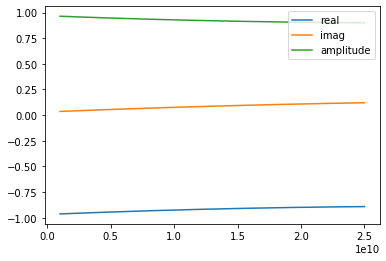

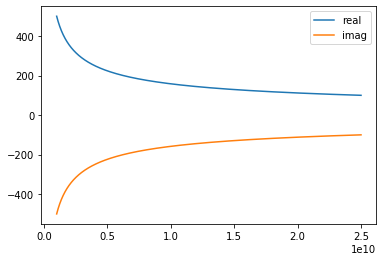

In [103]:
freqExp = numpy.linspace(1*10**9, 25*10**9, 1601)

S11Test = S11FitFunc(freqExp)
plt.plot(freqExp, S11Test.real, label="real")
plt.plot(freqExp, S11Test.imag, label="imag")
plt.plot(freqExp, numpy.absolute(S11Test), label="amplitude")
plt.legend()
plt.show()

ZcSmoothTest = Zcharacteristic(freqExp, Ycss, SheetResistanceSignal, SheetResistanceGround)
plt.plot(freqExp, ZcSmoothTest.real, label="real")
plt.plot(freqExp, ZcSmoothTest.imag, label="imag")
plt.legend()
plt.show()

# The following creates analytical equations for the ABCD parameters with respect to the S parameters.

In [104]:
import sympy as sym
sym.init_printing()

In [105]:
A, B, C, D,V2inc, S11open, S11load, S11theory, Zload = sym.symbols("A,B,C,D,V2inc,S11open,S11load,S11theory,Zload")

OpenA = sym.Eq(1 + S11open, A*2*V2inc)
OpenC = sym.Eq((1 - S11open)/50, C*2*V2inc)

In [106]:
OpenA, OpenC

In [107]:
varA = sym.solve(OpenA, A)[0]
varC = sym.solve(OpenC, C)[0]

In [108]:
varA, varC

In [109]:
#Changed minus sings in second terms here
Eq1 = sym.Eq(varA*D - B*varC, 1)
Eq2 = sym.Eq(1 + S11load, varA*V2inc*(1 + S11theory) + B*V2inc*(1+S11theory)/Zload)
Eq3 = sym.Eq((1 - S11load)/50, varC*V2inc*(1+S11theory) + D*V2inc*(1+S11theory)/Zload)

In [110]:
Eq1, Eq2, Eq3

In [111]:
BDV2solve = sym.solve([Eq1, Eq2, Eq3], B, D, V2inc)

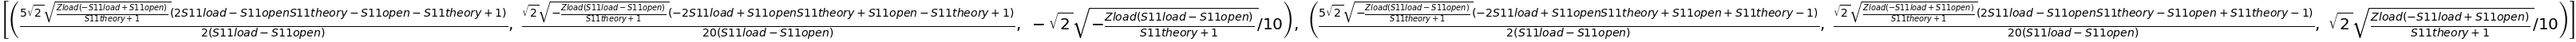

In [112]:
BDV2solve

In [113]:
varB = BDV2solve[0][0]
varD = BDV2solve[0][1]
varV2inc = BDV2solve[0][2]
varA = varA.subs(V2inc, varV2inc)
varC = varC.subs(V2inc, varV2inc)

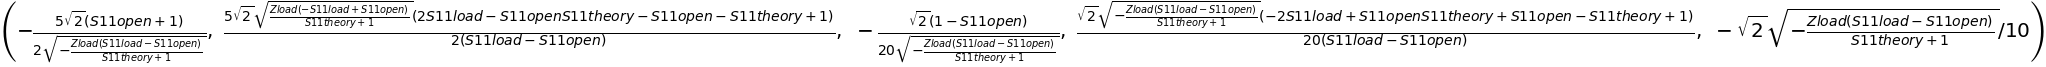

In [114]:
varA, varB, varC, varD, varV2inc

In [115]:
Zc = sym.Symbol("Zc")

In [116]:
Zc

In [117]:
varA = varA.subs(Zload, Zc * (1+S11theory)/(1-S11theory))
varB = varB.subs(Zload, Zc * (1+S11theory)/(1-S11theory))
varC = varC.subs(Zload, Zc * (1+S11theory)/(1-S11theory))
varD = varD.subs(Zload, Zc * (1+S11theory)/(1-S11theory))

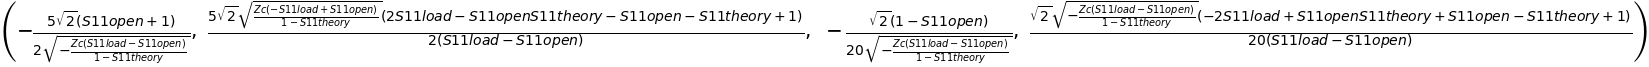

In [118]:
varA, varB, varC, varD

In [119]:
funcA = sym.lambdify((S11open, S11load, Zc, S11theory), varA)
funcB = sym.lambdify((S11open, S11load, Zc, S11theory), varB)
funcC = sym.lambdify((S11open, S11load, Zc, S11theory), varC)
funcD = sym.lambdify((S11open, S11load, Zc, S11theory), varD)

In [120]:
def CreateABCDFeedingLine(S11open, S11load, Zc, S11theory):
    A = funcA(S11open, S11load, Zc, S11theory)
    B = funcB(S11open, S11load, Zc, S11theory)
    C = funcC(S11open, S11load, Zc, S11theory)
    D = funcD(S11open, S11load, Zc, S11theory)
    
    return pandas.DataFrame({"A": A, "B": B, "C": C, "D": D})

def CreateSaveMatrix(frequency, SDataFrame):
    freq = pandas.DataFrame({"Frequency": frequency})
    SReal = SDataFrame.applymap(numpy.real).rename(columns={"S11": "ReS11", "S21": "ReS21", "S12": "ReS12", "S22": "ReS22"})
    SImag = SDataFrame.applymap(numpy.imag).rename(columns={"S11": "ImS11", "S21": "ImS21", "S12": "ImS12", "S22": "ImS22"})
    SAmp = SDataFrame.applymap(numpy.absolute).rename(columns={"S11": "AmpS11", "S21": "AmpS21", "S12": "AmpS12", "S22": "AmpS22"})
    SPhase = SDataFrame.applymap(numpy.angle).rename(columns={"S11": "PhaseS11", "S21": "PhaseS21", "S12": "PhaseS12", "S22": "PhaseS22"})
    SPhaseUnwrapped = SPhase.apply(numpy.unwrap).rename(columns={"PhaseS11": "UnwrappedPhaseS11", "PhaseS21": "UnwrappedPhaseS21", "PhaseS12": "UnwrappedPhaseS12", "PhaseS22": "UnwrappedPhaseS22"})
    
    return pandas.concat([freq, SReal, SImag, SAmp, SPhase, SPhaseUnwrapped], axis=1)

def CreateABCDSaveMatrix(frequency, ABCD):
    freq = pandas.DataFrame({"Frequency": frequency})
    ABCDReal = ABCD.applymap(numpy.real).rename(columns={"A": "ReA", "B": "ReB", "C": "ReC", "D": "ReD"})
    ABCDImag = ABCD.applymap(numpy.imag).rename(columns={"A": "ImA", "B": "ImB", "C": "ImC", "D": "ImD"})
    ABCDAmp = ABCD.applymap(numpy.absolute).rename(columns={"A": "AmpA", "B": "AmpB", "C": "AmpC", "D": "AmpD"})
    ABCDPhase = ABCD.applymap(numpy.angle).rename(columns={"A": "PhaseA", "B": "PhaseB", "C": "PhaseC", "D": "PhaseD"})
    ABCDPhaseUnwrapped = ABCDPhase.apply(numpy.unwrap).rename(columns={"PhaseA": "UnwrappedPhaseA", "PhaseB": "UnwrappedPhaseB", "PhaseC": "UnwrappedPhaseC", "PhaseD": "UnwrappedPhaseD"})
    
    return pandas.concat([freq, ABCDReal, ABCDImag, ABCDAmp, ABCDPhase, ABCDPhaseUnwrapped], axis=1)

# Now let us solve for the reciprocal A'B'C'D' Matrix for propagation in the other direction

In [121]:
import sympy as sym

A, B, C, D, Ap, Bp, Cp, Dp = sym.symbols("A,B,C,D,Ap,Bp,Cp,Dp")

Eq1 = sym.Eq(A, Dp/(Ap*Dp-Bp*Cp))
Eq2 = sym.Eq(B, Bp/(Ap*Dp-Bp*Cp))
Eq3 = sym.Eq(C, Cp/(Ap*Dp-Bp*Cp))
Eq4 = sym.Eq(D, Ap/(Ap*Dp-Bp*Cp))

solution = sym.solve([Eq1,Eq2,Eq3,Eq4], Ap, Bp, Cp, Dp)[0]

In [122]:
solution

In [123]:
AprimeFromABCD = sym.lambdify((A,B,C,D), solution[0])
BprimeFromABCD = sym.lambdify((A,B,C,D), solution[1])
CprimeFromABCD = sym.lambdify((A,B,C,D), solution[2])
DprimeFromABCD = sym.lambdify((A,B,C,D), solution[3])

# 2. Now let's load in the loaded and cut

In [124]:
import tkinter as tk
import tkinter.filedialog as fd

root = tk.Tk()
fileS11open = fd.askopenfilename(parent=root, initialdir="H:\\My Documents\\Physics\\PhD Work\\Samples\\Strasbourg Samples", title="S11 cut antenna")
fileS11load = fd.askopenfilename(parent=root, title="S11 loaded antenna")

root.withdraw()

print(fileS11open)
print(fileS11load)

//uniwa.uwa.edu.au/userhome/students6/22159666/My Documents/Physics/PHD Formal/Publications/Spin-wave Papers/Data/2.ExperimentLoadedAndCut/20210920_pf52010611_dev4_cut_rightprobe_2.45kO.s2p
//uniwa.uwa.edu.au/userhome/students6/22159666/My Documents/Physics/PHD Formal/Publications/Spin-wave Papers/Data/2.ExperimentLoadedAndCut/2020-05-27_pf520181219_dev12_7.0_2407_ref.csv


In [125]:
fileExtensionopen = fileS11open.split(".")[-1]
fileExtensionload = fileS11load.split(".")[-1]
print(fileExtensionopen)
print(fileExtensionload)

Stocheck = "S11"

window = 101
polyOrder = 3

if(fileExtensionopen == "s2p"):
    p_S11open = pandas.read_csv(fileS11open, header=0, skiprows=8, delimiter=' ', names=["# frequency", " Re(S11)", " Im(S11)", " Re(S21)", " Im(S21)", " Re(S12)", " Im(S12)", " Re(S22)", " Im(S22)"], engine='python')
    S11open = savgol_filter(p_S11open[f" Re({Stocheck})"], window, polyOrder) + 1j * savgol_filter(p_S11open[f" Im({Stocheck})"], window, polyOrder)
elif(fileExtensionopen == "csv"):
    p_S11open = pandas.read_csv(fileS11open, header=0, delimiter=',', engine='python')
    S11open = savgol_filter(p_S11open[f" Re{Stocheck}"], window, polyOrder) + 1j * savgol_filter(p_S11open[f" Im{Stocheck}"], window, polyOrder) 

if(fileExtensionload == "s2p"):
    p_S11load = pandas.read_csv(fileS11load, header=0, skiprows=8, delimiter=' ', names=["# frequency", " Re(S11)", " Im(S11)", " Re(S21)", " Im(S21)", " Re(S12)", " Im(S12)", " Re(S22)", " Im(S22)"], engine='python')
    S11load = savgol_filter(p_S11load[f" Re({Stocheck})"], window, polyOrder) + 1j * savgol_filter(p_S11load[f" Im({Stocheck})"], window, polyOrder)
elif(fileExtensionload == "csv"):
    p_S11load = pandas.read_csv(fileS11load, header=0, delimiter=',', engine='python')
    S11load = savgol_filter(p_S11load[f" Re{Stocheck}"], window, polyOrder) + 1j * savgol_filter(p_S11load[f" Im{Stocheck}"], window, polyOrder)
    
freq = p_S11open["# frequency"]
S11antenna = S11FitFunc(freq)  

s2p
csv


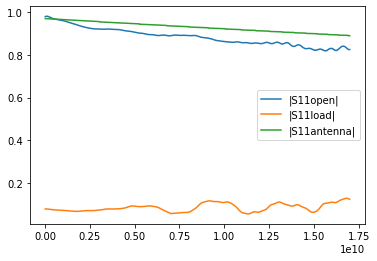

In [126]:
plt.plot(freq, numpy.absolute(S11open), label="|S11open|")
plt.plot(freq, numpy.absolute(S11load), label="|S11load|")
plt.plot(freq, numpy.absolute(S11antenna), label="|S11antenna|")
plt.legend()
plt.show()

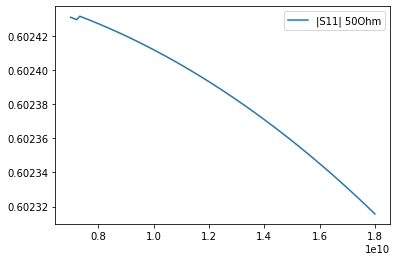

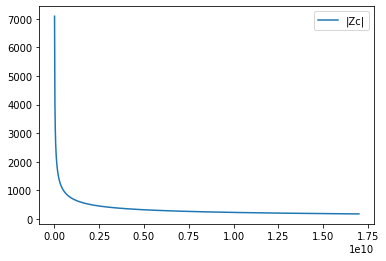

In [127]:
S11antenna = S11FitFunc(freq)

Ycss = 1.9680 * 10 ** -10 * 1j
SheetResistanceSignal = SheetResistance(rhoAl, tAl, ws)
SheetResistanceGround = SheetResistance(rhoAl, tAl, wgr)

zcharacteristic = Zcharacteristic(freq, Ycss, SheetResistanceSignal, SheetResistanceGround)

ABCDFeedingLine = CreateABCDFeedingLine(S11open, S11load, zcharacteristic, S11antenna)

Aprime = AprimeFromABCD(A,B,C,D)
Bprime = AprimeFromABCD(A,B,C,D)
Cprime = AprimeFromABCD(A,B,C,D)
Dprime = AprimeFromABCD(A,B,C,D)

plt.plot(frequencies, numpy.absolute(S11FiftyOhm), label="|S11| 50Ohm")
plt.legend()
plt.show()

plt.plot(freq, numpy.absolute(zcharacteristic), label="|Zc|")
plt.legend()
plt.show()

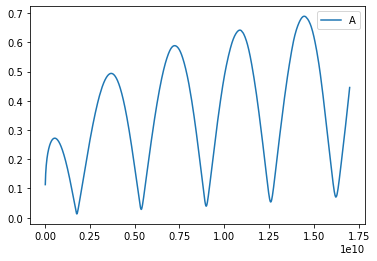

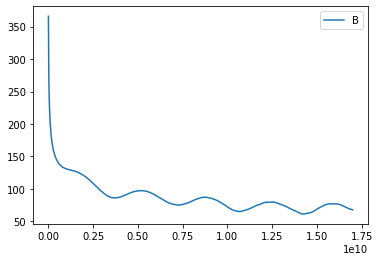

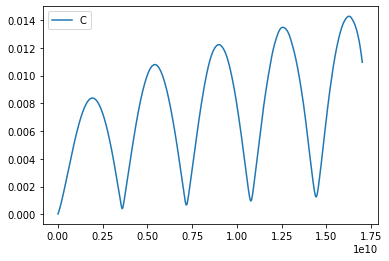

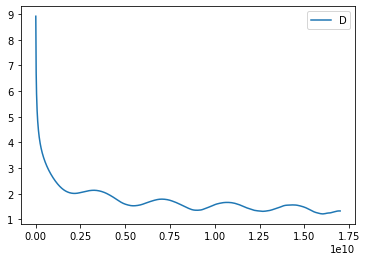

In [128]:
plt.plot(freq, numpy.absolute(ABCDFeedingLine["A"]), label="A")
plt.legend()
plt.show()

plt.plot(freq, numpy.absolute(ABCDFeedingLine["B"]), label="B")
plt.legend()
plt.show()

plt.plot(freq, numpy.absolute(ABCDFeedingLine["C"]), label="C")
plt.legend()
plt.show()

plt.plot(freq, numpy.absolute(ABCDFeedingLine["D"]), label="D")
plt.legend()
plt.show()

# Now we need to de-embed the ABCD matrix from the total measurement
# To make this easier we will create conversion function ABCD-> S and S->ABCD

In [129]:
def S11FromABCD(a, b, c, d, z01, z02):
    return (a*z02 + b - c*numpy.conjugate(z01)*z02 - d*numpy.conjugate(z01))/(a*z02 + b + c*z01*z02 + d*z01)

def S12FromABCD(a, b, c, d, z01, z02, r01, r02):
    return 2*(a*d - b*c)*numpy.sqrt(r01*r02) / (a*z02 + b + c*z01*z02 + d*z01)
    
def S21FromABCD(a, b, c, d, z01, z02, r01, r02):
    return 2*numpy.sqrt(r01*r02) / (a*z02 + b + c*z01*z02 + d*z01)

def S22FromABCD(a, b, c, d, z01, z02):
    return (-a*numpy.conjugate(z02) + b - c*z01*numpy.conjugate(z02) + d*z01) / (a*z02 + b + c*z01*z02 + d*z01)

def AFromS(S11, S21, S12, S22, z01, z02, r01, r02):
    return ((numpy.conjugate(z01) + S11*z01)*(1-S22) + S12*S21*z01) / (2*S21*numpy.sqrt(r01*r02))

def BFromS(S11, S21, S12, S22, z01, z02, r01, r02):
    return ((numpy.conjugate(z01) + S11*z01)*(numpy.conjugate(z02)+S22*z02) - S12*S21*z01*z02) / (2*S21*numpy.sqrt(r01*r02))

def CFromS(S11, S21, S12, S22, z01, z02, r01, r02):
    return ((1-S11)*(1-S22)-S12*S21) / (2*S21*numpy.sqrt(r01*r02))

def DFromS(S11, S21, S12, S22, z01, z02, r01, r02):
    return ((1-S11) * (numpy.conjugate(z02)+S22*z02) + S12*S21*z02) / (2*S21 * numpy.sqrt(r01*r02))

In [130]:
def ABCDFromS(S, z01, z02, r01, r02):
    A = AFromS(S["S11"],S["S21"],S["S12"],S["S22"], z01, z02, r01, r02)
    B = BFromS(S["S11"],S["S21"],S["S12"],S["S22"], z01, z02, r01, r02)
    C = CFromS(S["S11"],S["S21"],S["S12"],S["S22"], z01, z02, r01, r02)
    D = DFromS(S["S11"],S["S21"],S["S12"],S["S22"], z01, z02, r01, r02)
    
    return pandas.DataFrame({"A": A,"B": B, "C": C, "D": D})

def SFromABCD(ABCD, z01, z02, r01, r02):
    S11 = S11FromABCD(ABCD["A"], ABCD["B"], ABCD["C"], ABCD["D"], z01, z02)
    S21 = S21FromABCD(ABCD["A"], ABCD["B"], ABCD["C"], ABCD["D"], z01, z02, r01, r02)
    S12 = S12FromABCD(ABCD["A"], ABCD["B"], ABCD["C"], ABCD["D"], z01, z02, r01, r02)
    S22 = S22FromABCD(ABCD["A"], ABCD["B"], ABCD["C"], ABCD["D"], z01, z02)
    
    return pandas.DataFrame({"S11": S11, "S21": S21, "S12": S12, "S22": S22})

# 3. Let's load in the signal and reference data

In [131]:
import tkinter as tk
import tkinter.filedialog as fd

root = tk.Tk()
fileSonband = fd.askopenfilename(parent=root, initialdir="H:\\My Documents\\Physics\\PhD Work\\Samples\\Strasbourg Samples", title="VNA on band measurement")
fileSoffband = fd.askopenfilename(parent=root, title="VNA reference measurement")

root.withdraw()

print(fileSonband)
print(fileSoffband)

//uniwa.uwa.edu.au/userhome/students6/22159666/My Documents/Physics/PHD Formal/Publications/Spin-wave Papers/Data/3.ExperimentSignalAndReference/2020-05-27_pf520181219_dev12_1.3157894736842104_600.csv
//uniwa.uwa.edu.au/userhome/students6/22159666/My Documents/Physics/PHD Formal/Publications/Spin-wave Papers/Data/3.ExperimentSignalAndReference/2020-05-27_pf520181219_dev12_7.0_2407_ref.csv


In [132]:
fileExtension = fileSonband.split(".")[-1]

print(fileExtension)

if(fileExtension == "s2p"):
    pSOnBand = pandas.read_csv(fileSonband, header=0, skiprows=8, delimiter=' ', names=["# frequency", " ReS11", " ImS11", " ReS21", " ImS21", " ReS12", " ImS12", " ReS22", " ImS22"], engine='python')
    pSOffBand = pandas.read_csv(fileSoffband, header=0, skiprows=8, delimiter=' ', names=["# frequency", " ReS11", " ImS11", " ReS21", " ImS21", " ReS12", " ImS12", " ReS22", " ImS22"], engine='python')
else:
    pSOnBand = pandas.read_csv(fileSonband, header=0, delimiter=',')
    pSOffBand = pandas.read_csv(fileSoffband, header=0, delimiter=',')

freqData = pSOnBand["# frequency"]

csv


In [133]:
pSOnBand

,# frequency,ReS11,ImS11,ReS21,ImS21,ReS12,ImS12,ReS22,ImS22
0,1.000000e+07,-0.081091,0.001898,0.000012,0.000005,0.000013,0.000006,-0.046315,0.001016
1,2.061875e+07,-0.080833,0.004029,0.000014,0.000016,0.000015,0.000015,-0.046017,0.002453
2,3.123750e+07,-0.080102,0.005894,0.000018,0.000024,0.000018,0.000026,-0.045285,0.003714
3,4.185625e+07,-0.079355,0.007750,0.000022,0.000032,0.000022,0.000033,-0.044592,0.004992
4,5.247500e+07,-0.078860,0.009559,0.000027,0.000037,0.000023,0.000034,-0.044162,0.006240
...,...,...,...,...,...,...,...,...,...
1596,1.695752e+10,-0.064374,-0.098909,-0.004565,-0.000308,-0.004541,-0.000372,-0.069044,-0.063585
1597,1.696814e+10,-0.068496,-0.107682,-0.004559,-0.000232,-0.004476,-0.000293,-0.077101,-0.072600
1598,1.697876e+10,-0.060089,-0.113693,-0.004521,-0.000187,-0.004498,-0.000244,-0.073712,-0.082055
1599,1.698938e+10,-0.048352,-0.106207,-0.004556,-0.000075,-0.004483,-0.000116,-0.064006,-0.082568


In [134]:
def ToComplexData(pData, symmetric = False):
    output = pandas.DataFrame(data=numpy.zeros((pData.shape[0],4), dtype=numpy.complex), columns=["S11","S12","S21","S22"])
    outName = ["S11","S12","S21","S22"]
    if(not symmetric):
        inName = outName
    else:
        inName = ["S11","S21","S21","S11"]
        
    for i in range(len(outName)):
        x = outName[i]
        y = inName[i]
         
        output[x] = pData[" Re"+y] + 1j*pData[" Im"+y]
            
    return output

def SimulationToComplex(pData, symmetric = False):
    output = pandas.DataFrame(data=numpy.zeros((pData.shape[0],4), dtype=numpy.complex), columns=["S11","S12","S21","S22"])
    outName = ["S11","S12","S21","S22"]
    if(not symmetric):
        inName = outName
    else:
        inName = ["S11","S21","S21","S11"]
        
    for i in range(len(outName)):
        x = outName[i]
        y = inName[i]
         
        output[x] = pData[" Real("+y+")"] + 1j*pData[" Imag("+y+")"]
            
    return output

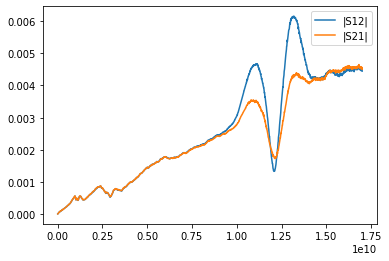

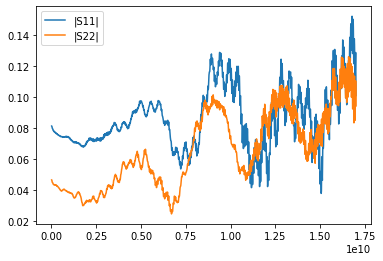

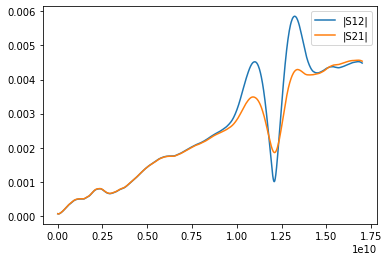

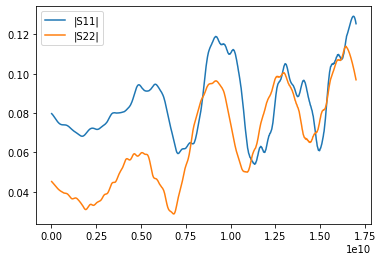

In [135]:
freqData = pSOnBand["# frequency"]
indexRange = slice(0,None)
freqData = freqData[indexRange].reset_index(drop=True)
SOnBand = ToComplexData(pSOnBand)[indexRange].reset_index(drop=True)
SOffBand = ToComplexData(pSOffBand)[indexRange].reset_index(drop=True)

deg = 180
useAverageS11 = False
subtractFirst = False

if subtractFirst:
    SOnBand = SOnBand - SOffBand
#     SOnBand["S11"] = SOnBand["S11"] - SOffBand["S11"]
#     SOnBand["S22"] = SOnBand["S22"] - SOffBand["S22"]

#SOnBand["S21"] = SOnBand["S21"] - SOffBand["S21"]
#SOnBand["S12"] = SOnBand["S12"] - SOffBand["S12"]
#SOnBand["S11"] = SOnBand["S11"] - SOffBand["S21"]
#SOnBand["S22"] = SOnBand["S22"] - SOffBand["S12"]
if useAverageS11:
    SOnBand["S11"] = numpy.average(numpy.array([SOnBand["S11"], SOnBand["S22"]*numpy.exp(1j*deg*numpy.pi/180)]), axis=0)
    SOnBand["S22"] = SOnBand["S11"]
    SOffBand["S11"] = numpy.average(numpy.array([SOffBand["S11"], SOffBand["S22"]*numpy.exp(1j*deg*numpy.pi/180)]), axis=0)
    SOffBand["S22"] = SOffBand["S11"]

#SOnBand["S22"] = SOnBand["S11"]

plt.plot(freqData, numpy.absolute(SOnBand["S12"]), label="|S12|")
plt.plot(freqData, numpy.absolute(SOnBand["S21"]), label="|S21|")
plt.legend()
plt.show()

plt.plot(freqData, numpy.absolute(SOnBand["S11"]), label="|S11|")
plt.plot(freqData, numpy.absolute(SOnBand["S22"]), label="|S22|")
plt.legend()
plt.show()


#Smoothing
window = 101
polyOrder = 3

SOnBand = SmoothDataFrame(SOnBand, window, polyOrder)
SOffBand = SmoothDataFrame(SOffBand, window, polyOrder)

#SOnBand = SOnBand - SOffBand

freqData = pandas.Series(savgol_filter(freqData, window, polyOrder))

plt.plot(freqData, numpy.absolute(SOnBand["S12"]), label="|S12|")
plt.plot(freqData, numpy.absolute(SOnBand["S21"]), label="|S21|")
plt.legend()
plt.show()

plt.plot(freqData, numpy.absolute(SOnBand["S11"]), label="|S11|")
plt.plot(freqData, numpy.absolute(SOnBand["S22"]), label="|S22|")
plt.legend()
plt.show()

In [136]:
ABCDonBand = ABCDFromS(SOnBand, 50, 50, 50, 50)
ABCDoffBand = ABCDFromS(SOffBand, 50, 50, 50, 50)

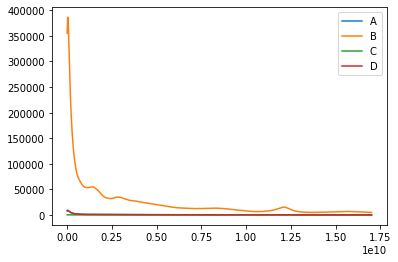

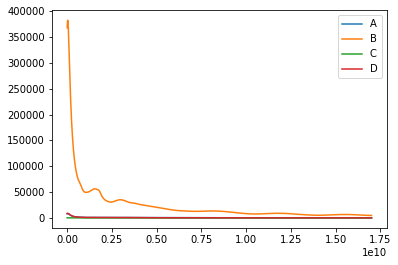

In [137]:
plt.plot(freqData, numpy.absolute(ABCDonBand["A"]), label="A")
plt.plot(freqData, numpy.absolute(ABCDonBand["B"]), label="B")
plt.plot(freqData, numpy.absolute(ABCDonBand["C"]), label="C")
plt.plot(freqData, numpy.absolute(ABCDonBand["D"]), label="D")
plt.legend()
plt.show()

plt.plot(freqData, numpy.absolute(ABCDoffBand["A"]), label="A")
plt.plot(freqData, numpy.absolute(ABCDoffBand["B"]), label="B")
plt.plot(freqData, numpy.absolute(ABCDoffBand["C"]), label="C")
plt.plot(freqData, numpy.absolute(ABCDoffBand["D"]), label="D")
plt.legend()
plt.show()

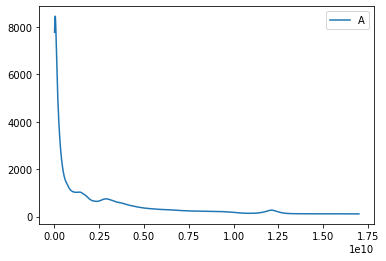

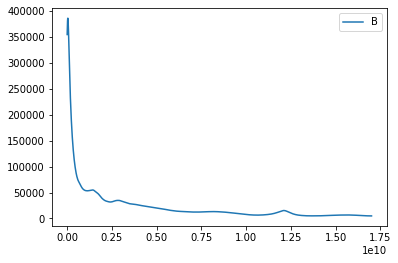

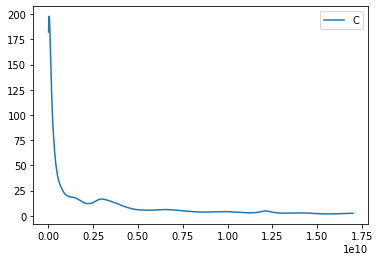

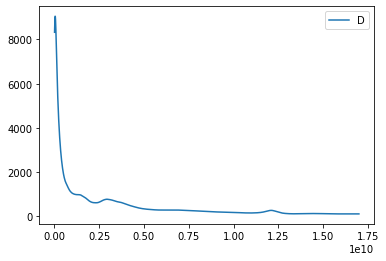

In [138]:
start = 0

plt.plot(freqData[start::], numpy.absolute(ABCDonBand["A"][start::]), label="A")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(ABCDonBand["B"][start::]), label="B")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(ABCDonBand["C"][start::]), label="C")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(ABCDonBand["D"][start::]), label="D")
plt.legend()
plt.show()

# Solving the De-embedding analytically

In [139]:
A,B,C,D,Ain,Bin,Cin,Din = sym.symbols("A,B,C,D,Ain,Bin,Cin,Din")

In [140]:
ABCDtot = sym.Matrix([[A,B],[C,D]])
ABCDin = sym.Matrix([[Ain,Bin],[Cin,Din]])

Aout = AprimeFromABCD(Ain,Bin,Cin,Din)
Bout = BprimeFromABCD(Ain,Bin,Cin,Din)
Cout = CprimeFromABCD(Ain,Bin,Cin,Din)
Dout = DprimeFromABCD(Ain,Bin,Cin,Din)

ABCDout = sym.Matrix([[Aout, Bout],[Cout,Dout]])

In [141]:
ABCDsw = sym.simplify(ABCDin ** -1 * ABCDtot * ABCDout ** -1)

In [142]:
ABCDsw

⎡  Ain⋅(A⋅Din - Bin⋅C) - Cin⋅(B⋅Din - Bin⋅D)    -Bin⋅(A⋅Din - Bin⋅C) + Din⋅(B⋅
⎢  ─────────────────────────────────────────    ──────────────────────────────
⎢              Ain⋅Din - Bin⋅Cin                            Ain⋅Din - Bin⋅Cin 
⎢                                                                             
⎢-(Ain⋅(A⋅Cin - Ain⋅C) + Cin⋅(Ain⋅D - B⋅Cin))   Bin⋅(A⋅Cin - Ain⋅C) + Din⋅(Ain
⎢─────────────────────────────────────────────  ──────────────────────────────
⎣              Ain⋅Din - Bin⋅Cin                            Ain⋅Din - Bin⋅Cin 

Din - Bin⋅D)⎤
────────────⎥
            ⎥
            ⎥
⋅D - B⋅Cin) ⎥
─────────── ⎥
            ⎦

In [143]:
Asw = ABCDsw[0,0]
Bsw = ABCDsw[0,1]
Csw = ABCDsw[1,0]
Dsw = ABCDsw[1,1]

AswDeembed = sym.lambdify((A, B, C, D, Ain, Bin, Cin, Din), Asw)
BswDeembed = sym.lambdify((A, B, C, D, Ain, Bin, Cin, Din), Bsw)
CswDeembed = sym.lambdify((A, B, C, D, Ain, Bin, Cin, Din), Csw)
DswDeembed = sym.lambdify((A, B, C, D, Ain, Bin, Cin, Din), Dsw)

In [144]:
def SolveABCDsw(Atot, Afeed):
    Asw = AswDeembed(Atot["A"],Atot["B"],Atot["C"],Atot["D"],Afeed["A"],Afeed["B"],Afeed["C"],Afeed["D"])
    Bsw = BswDeembed(Atot["A"],Atot["B"],Atot["C"],Atot["D"],Afeed["A"],Afeed["B"],Afeed["C"],Afeed["D"])
    Csw = CswDeembed(Atot["A"],Atot["B"],Atot["C"],Atot["D"],Afeed["A"],Afeed["B"],Afeed["C"],Afeed["D"])
    Dsw = DswDeembed(Atot["A"],Atot["B"],Atot["C"],Atot["D"],Afeed["A"],Afeed["B"],Afeed["C"],Afeed["D"])
    
    return pandas.DataFrame({"A": Asw, "B": Bsw, "C": Csw, "D": Dsw})

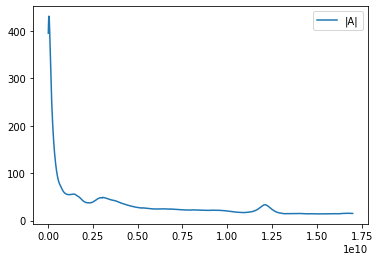

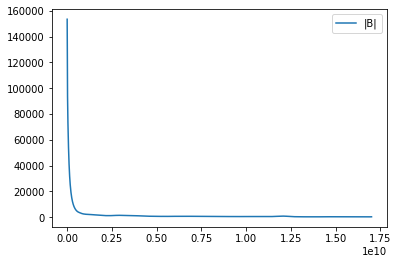

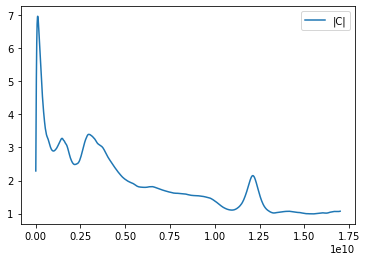

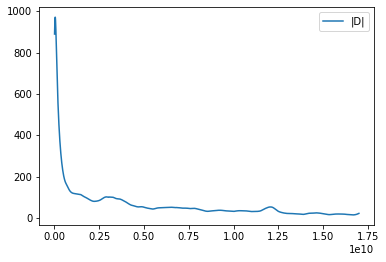

In [145]:
if freq.size != freqData.size:
    ABCDFeedInterped = InterpolateABCD(ABCDFeedingLine, freq, freqData)
else:
    ABCDFeedInterped = ABCDFeedingLine.copy(deep=True)
    
ABCDswOnData = SolveABCDsw(ABCDonBand, ABCDFeedInterped)
ABCDswOffData = SolveABCDsw(ABCDoffBand, ABCDFeedInterped)

plt.plot(freqData, numpy.absolute(ABCDswOnData["A"]), label="|A|")
plt.legend()
plt.show()

plt.plot(freqData, numpy.absolute(ABCDswOnData["B"]), label="|B|")
plt.legend()
plt.show()

plt.plot(freqData, numpy.absolute(ABCDswOnData["C"]), label="|C|")
plt.legend()
plt.show()

plt.plot(freqData, numpy.absolute(ABCDswOnData["D"]), label="|D|")
plt.legend()
plt.show()

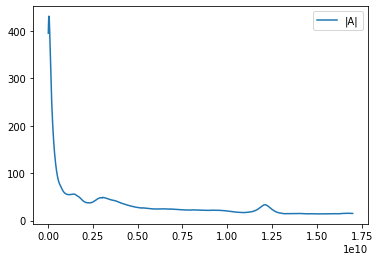

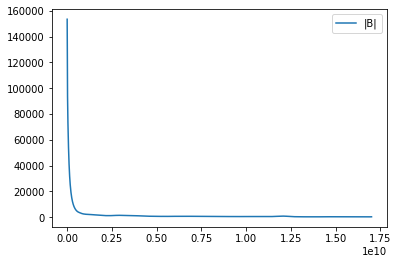

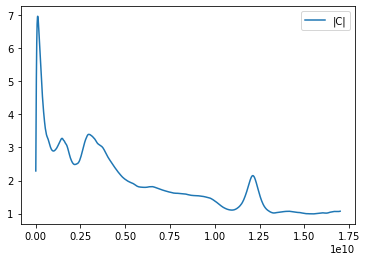

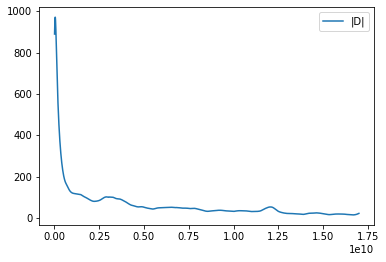

In [146]:
start = 0

plt.plot(freqData[start::], numpy.absolute(ABCDswOnData["A"][start::]), label="|A|")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(ABCDswOnData["B"][start::]), label="|B|")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(ABCDswOnData["C"][start::]), label="|C|")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(ABCDswOnData["D"][start::]), label="|D|")
plt.legend()
plt.show()

In [147]:
SOnData = SFromABCD(ABCDswOnData, 50, 50, 50, 50)
SOffData = SFromABCD(ABCDswOffData, 50, 50, 50, 50)

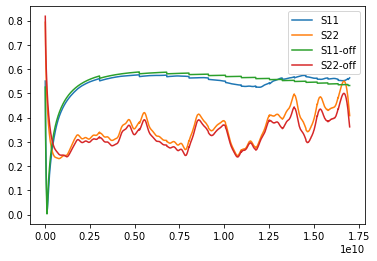

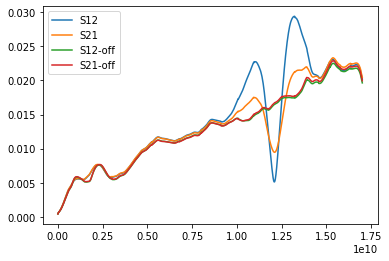

In [148]:
index = slice(0,None)

plt.plot(freqData,numpy.absolute(SOnData["S11"]), label="S11")
plt.plot(freqData,numpy.absolute(SOnData["S22"]), label="S22")
plt.plot(freqData,numpy.absolute(SOffData["S11"]), label="S11-off")
plt.plot(freqData,numpy.absolute(SOffData["S22"]), label="S22-off")
plt.legend()
plt.show()

plt.plot(freqData[index],numpy.absolute(SOnData["S12"][index]), label="S12")
plt.plot(freqData[index],numpy.absolute(SOnData["S21"][index]), label="S21")
plt.plot(freqData[index],numpy.absolute(SOffData["S12"][index]), label="S12-off")
plt.plot(freqData[index],numpy.absolute(SOffData["S21"][index]), label="S21-off")

plt.legend()
plt.show()

In [149]:
Ssubtract = SOnData - SOffData

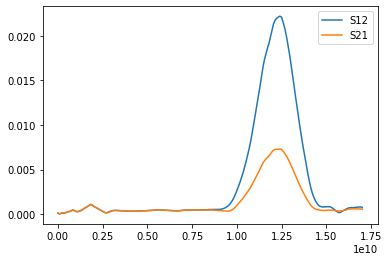

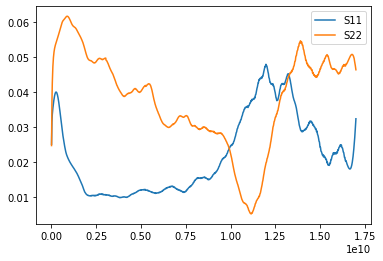

In [150]:
indexRange = slice(0,None)

plt.plot(freqData, numpy.absolute(Ssubtract["S12"]), label="S12")
plt.plot(freqData, numpy.absolute(Ssubtract["S21"]), label="S21")
plt.legend()
plt.show()

plt.plot(freqData[indexRange], numpy.absolute(Ssubtract["S11"])[indexRange], label="S11")
plt.plot(freqData[indexRange], numpy.absolute(Ssubtract["S22"])[indexRange], label="S22")
plt.legend()
plt.show()

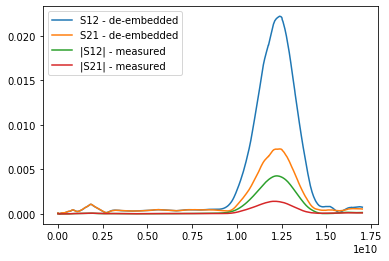

In [151]:
start = 0

plt.plot(freqData[start::], numpy.absolute(Ssubtract["S12"][start::]), label="S12 - de-embedded")
plt.plot(freqData[start::], numpy.absolute(Ssubtract["S21"][start::]), label="S21 - de-embedded")
plt.plot(freqData, numpy.absolute(SOnBand["S12"] - SOffBand["S12"]), label="|S12| - measured")
plt.plot(freqData, numpy.absolute(SOnBand["S21"] - SOffBand["S21"]), label="|S21| - measured")
#plt.plot(freqData, numpy.absolute(Ssubtract["S11"]), label="S11")
#plt.plot(freqData, numpy.absolute(Ssubtract["S22"]), label="S22")
plt.legend()
plt.show()

# 4. Compare to the simulation

In [152]:
root = tk.Tk()
fileS12 = fd.askopenfilename(parent=root, initialdir="H:\\My Documents\\Physics\\PhD Work\\Simulation Code\\Python Simulation Results", title="S12 simulation")
fileS21 = fd.askopenfilename(parent=root, title="S21 simulation")

root.withdraw()
print(fileS12, fileS21)

//uniwa.uwa.edu.au/userhome/students6/22159666/My Documents/Physics/PHD Formal/Publications/Spin-wave Papers/Data/4.SimulationForComparison - NewCorrection/2022-05-15_distance_Antennas_-2.464e-06_600Oe_corrected_20220515_sub.csv //uniwa.uwa.edu.au/userhome/students6/22159666/My Documents/Physics/PHD Formal/Publications/Spin-wave Papers/Data/4.SimulationForComparison - NewCorrection/2022-05-15_distance_Antennas_2.464e-06_600Oe_corrected_20220515_sub.csv


In [153]:
pS12 = pandas.read_csv(fileS12, header=0, delimiter=",")
pS21 = pandas.read_csv(fileS21, header=0, delimiter=",")

In [154]:
freqSimulation = pS12["# Frequency"]
S12 = SimulationToComplex(pS12, True)
S21 = SimulationToComplex(pS21, True)


SMatrixSimulation = S12
SMatrixSimulation["S21"] = S21["S21"]

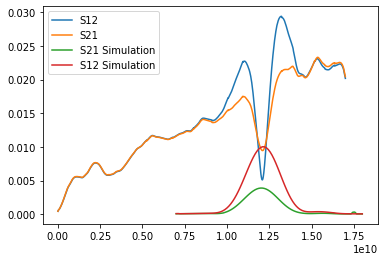

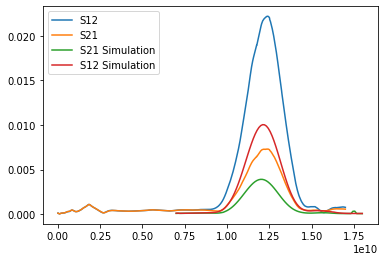

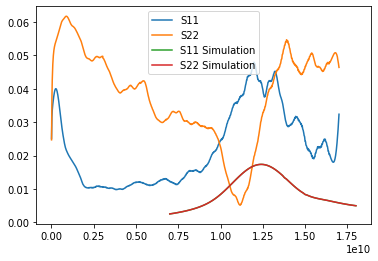

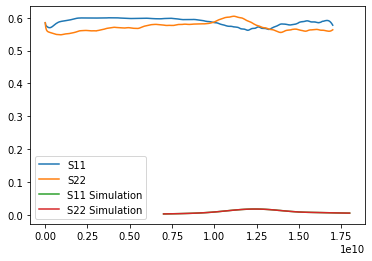

In [155]:
start = 0

plt.plot(freqData[start::], numpy.absolute(SOnData["S12"][start::]), label="S12")
plt.plot(freqData[start::], numpy.absolute(SOnData["S21"][start::]), label="S21")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S21"]), label="S21 Simulation")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S12"]), label="S12 Simulation")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(Ssubtract["S12"][start::]), label="S12")
plt.plot(freqData[start::], numpy.absolute(Ssubtract["S21"][start::]), label="S21")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S21"]), label="S21 Simulation")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S12"]), label="S12 Simulation")
plt.legend()
plt.show()

plt.plot(freqData[start::], numpy.absolute(Ssubtract["S11"][start::]), label="S11")
plt.plot(freqData[start::], numpy.absolute(Ssubtract["S22"][start::]), label="S22")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S11"]), label="S11 Simulation")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S22"]), label="S22 Simulation")
plt.legend()
plt.show()

plt.plot(freqData[start::], -1 * numpy.absolute(Ssubtract["S11"][start::]) + 0.61, label="S11")
plt.plot(freqData[start::], -1 * numpy.absolute(Ssubtract["S22"][start::]) + 0.61, label="S22")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S11"]), label="S11 Simulation")
plt.plot(freqSimulation, numpy.absolute(SMatrixSimulation["S22"]), label="S22 Simulation")
plt.legend()
plt.show()